# Calculate travel times

This stage computes the travel times from all the points of a three-dimensional grid to each seismic station. The travel times grid allows for shifting the data according to every tested point source point in the beamforming response calculation.

This tutorial utilizes the `PyKonal` package to compute travel times in a space-dependant velocity medium. The package documentation and installation procedure are described at https://github.com/malcolmw/pykonal. Please acknowledge White et al. (2020) if using the package.

In [152]:
import glob
import h5py
import numpy as np
import obspy
import os
import pandas as pd
import pykonal
import tqdm

from matplotlib import pyplot as plt
from pykonal.transformations import geo2sph, sph2geo

## Read velocity model

The velocity model of Karabulut et al. (2011) is downloaded and accessed with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for the later compatibility with `pykonal`. 

Text(0.5, 0, 'Depth (km)')

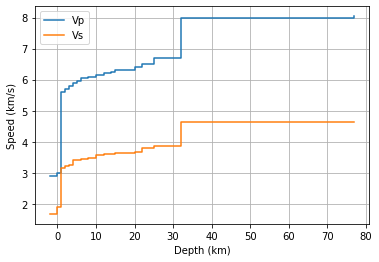

In [153]:
FILEPATH_VELOCITY = "../data/velocity_model_Karabulut2011.csv"
SEISMIC_PHASES = ["Vp", "Vs"]

# Read velocity model
velocity_model = pd.read_csv(FILEPATH_VELOCITY, index_col=0)

# Convert everything in km
for column in ("z_top", *SEISMIC_PHASES):
    velocity_model[column] /= 1000
velocity_model = velocity_model.set_index("z_top")

# Display velocity model dataframe
velocity_model.head()

# Plot
ax = velocity_model.plot(y=SEISMIC_PHASES, grid="true", drawstyle="steps-post")
ax.set_ylabel("Speed (km/s)")
ax.set_xlabel("Depth (km)")

## Interpolate velocity model at depth

We calculate the travel times on a finer grid than the model grid, so we need to interpolate the model. We do so while keeping the layer aspect of the model (last-value constant interpolation).

Text(0.5, 0, 'Depth (km)')

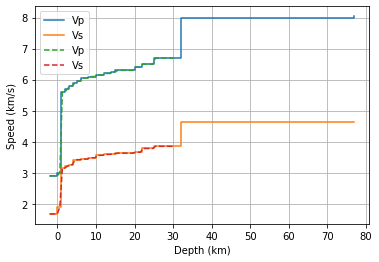

In [154]:
# The surface extents are in degrees, the depth positive downwards and in km
WEST, EAST, SOUTH, NORTH, DOWN, UP = 30.20, 30.45, 40.60, 40.76, 30.0, -2.0
GRID_SIZE = N_DEPTH, N_LAT, N_LON = 50, 20, 30

# Interpolate
depths = np.linspace(UP, DOWN, N_DEPTH)
longitudes = np.linspace(WEST, EAST, N_LON)
latitudes = np.linspace(SOUTH, NORTH, N_LAT)
velocity_model_interp = velocity_model.reindex(depths, method="ffill")

# Plot
ax = velocity_model.plot(y=SEISMIC_PHASES, grid="true", drawstyle="steps-post")
velocity_model_interp.plot(y=SEISMIC_PHASES, grid="true", ax=ax, style="--")
ax.set_ylabel("Speed (km/s)")
ax.set_xlabel("Depth (km)")

## Velocity grid in 3D

Because the overall package works in full three-dimensional coordinates, we tile the velocity model into a three-dimensional one. 

In [155]:
# Initialize grid
velocity_grid = dict()

# Assign coordinates
labels = "depth", "latitude", "longitude"
for label, coordinate in zip(labels, (depths, latitudes, longitudes)):
    velocity_grid[label] = coordinate

for phase in SEISMIC_PHASES:

    # Flip velocities to match the convention of the pykonal solver
    speed = np.flip(velocity_model_interp[phase]).to_numpy()
    velocity_grid[phase] = np.tile(speed[:, None, None], [N_LAT, N_LON])


## Station coordinates

**Note:** we use the inventory handler of obspy to gather the station coordinates. The `.get_coordinates()` method of the `inventory` object needs a `seed_id` to capture the response or coordinates of a given stream at a given station state in time. This cell gets the first entry of that inventory, noting that for more advanced application this should be handled with care.

In [142]:
FILEPATHS_INVENTORY = glob.glob("../data/*xml")

# Initialize coordinate dict
stations_coordinates = dict()
for filepath_inventory in tqdm.tqdm(FILEPATHS_INVENTORY, desc="Coordinates"):

    # Get inventory
    inventory = obspy.read_inventory(filepath_inventory)
    station_code, _ = os.path.splitext(os.path.basename(filepath_inventory))

    # Source position at station
    seed_id = inventory.get_contents()["channels"][0]
    stations_coordinates[station_code] = inventory.get_coordinates(seed_id)
    stations_coordinates[station_code]["depth"] = (
        1e-3 * stations_coordinates[station_code]["elevation"]
    )


Coordinates: 100%|██████████| 8/8 [00:00<00:00, 27.52it/s]


## Show model and stations

Give an overview of the input data.

Text(0, 0.5, 'Depth (km)')

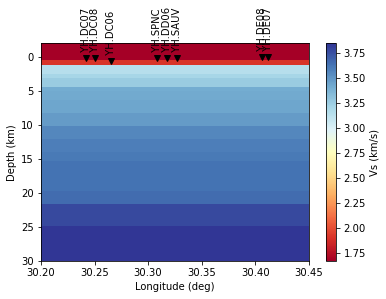

In [102]:
plt.imshow(
    velocity_grid["Vs"][:, 0, :],
    extent=[WEST, EAST, DOWN, UP],
    aspect="auto",
    origin="lower",
    cmap="RdYlBu"
)
plt.colorbar().set_label("Vs (km/s)")

for station, coordinate in stations_coordinates.items():
    xy = coordinate["longitude"], coordinate["depth"]
    plt.plot(*xy, "kv")
    plt.text(*xy, "  " + station, rotation="vertical", ha="center", va="bottom")

plt.xlabel("Longitude (deg)")
plt.ylabel("Depth (km)")


## Calculate travel times and save

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use.

In [145]:
FILEPATH_TRAVELTIMES = "../data/trave_times.h5"

step_depth = depths[1] - depths[0]
step_lat = np.deg2rad(latitudes[1] - latitudes[0])
step_lon = np.deg2rad(longitudes[1] - longitudes[0])

corner = latitudes.max(), longitudes.min(), depths.max() - step_depth
corner = geo2sph(corner)

# Initiliaze travel times
travel_times = dict()
for phase in SEISMIC_PHASES:
    travel_times[phase] = dict()

# Get travel times for every station
for station, coordinates in tqdm.tqdm(
    stations_coordinates.items(), desc="Travel times"
):

    for phase in SEISMIC_PHASES:

        # Source position at station
        coords = (
            coordinates["latitude"],
            coordinates["longitude"],
            coordinates["depth"],
        )

        # Initialize grid
        travel_times[phase][station] = np.zeros(
            velocity_grid[phase].shape, dtype=np.float32
        )

        # Solve Eikonal equation
        solver = pykonal.solver.PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = corner
        solver.velocity.node_intervals = step_depth, step_lat, step_lon
        solver.velocity.npts = N_DEPTH, N_LAT, N_LON
        solver.velocity.values = velocity_grid[phase][::-1]
        solver.src_loc = geo2sph(coords)

        # Solve travel times
        solver.solve()
        times = solver.tt.values[...]
        travel_times[phase][station] = times

# Save
with h5py.File(FILEPATH_TRAVELTIMES, mode="w") as root:
    for station in travel_times:
        root.create_group(station)
        for phase in travel_times[station]:
            data = travel_times[station][phase]
            root[station].create_dataset(phase, data=data, compression="gzip")


Travel times: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


## Show travel times at a given station

The travel times are calculated for every station with the Eikonal solver of the `pykonal` package. The travel times are then saved into a `h5` file for later use.

Text(0, 0.5, 'Depth (km)')

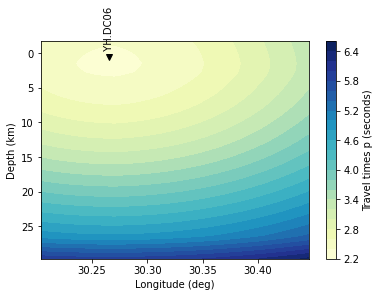

In [151]:
STATION = "YH.DC06"
SEISMIC_PHASE = "Vp"

plt.contourf(
    travel_times[SEISMIC_PHASE][STATION][:, 0, :],
    20, 
    extent=[WEST, EAST, DOWN, UP],
    origin="lower",
    cmap="YlGnBu"
)
plt.gca().invert_yaxis()
plt.colorbar().set_label(f"Travel times {SEISMIC_PHASE[1]} (seconds)")

# Station
x = stations_coordinates[STATION]["longitude"]
y = stations_coordinates[STATION]["depth"]
plt.plot(x, y, "kv")
plt.text(x, y, "  " + STATION, rotation="vertical", ha="center", va="bottom")
plt.xlabel("Longitude (deg)")
plt.ylabel("Depth (km)")